# Reproduce DDGemb method

In [1]:
!pip install torch_geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, EsmModel
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tqdm
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

In [3]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
class DDGPredictor(nn.Module):
    def __init__(self,
                 esm_model_name="facebook/esm2_t6_8M_UR50D",
                 embedding_dim=320,
                 conv_channels=128,
                 heads=4,
                 ffn_dim=256):
        super().__init__()

        # Device setup for trainable layers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ESM model on CPU
        self.tokenizer = AutoTokenizer.from_pretrained(esm_model_name)
        self.esm_model = EsmModel.from_pretrained(esm_model_name).eval()
        for param in self.esm_model.parameters():
            param.requires_grad = False

        # Convolutional encoder
        self.conv1d = nn.Conv1d(embedding_dim, conv_channels, kernel_size=3, padding=1)

        # Multi-head attention
        self.attention = nn.MultiheadAttention(embed_dim=conv_channels, num_heads=heads, batch_first=True)

        # Position-wise feedforward
        self.ffn = nn.Sequential(
            nn.Linear(conv_channels, ffn_dim),
            nn.ReLU(),
            nn.Linear(ffn_dim, conv_channels)
        )

        # Pooling layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(conv_channels * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            # nn.Linear(128, 1)
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

        # Move model parts to appropriate device

    def forward(self, wt_seq, mt_seq):
        # Tokenize and compute embeddings on CPU without gradients
        with torch.no_grad():
            wt_tokens = self.tokenizer(wt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)
            mt_tokens = self.tokenizer(mt_seq, return_tensors="pt", padding=True, truncation=True,max_length=1024)

            wt_tokens = {k: v.to(self.device) for k, v in wt_tokens.items()}
            mt_tokens = {k: v.to(self.device) for k, v in mt_tokens.items()}

            wt_embed = self.esm_model(**wt_tokens).last_hidden_state[:, 1:-1, :]  # remove [CLS] and [SEP]
            mt_embed = self.esm_model(**mt_tokens).last_hidden_state[:, 1:-1, :]

            d = (wt_embed - mt_embed)

        # Conv1D (expects B, C, L) and transpose back
        c = self.conv1d(d.transpose(1, 2)).transpose(1, 2)  # (B, L, C)
        # c = nn.Dropout(0.5)(c)
        # Multi-head attention + residual
        m, _ = self.attention(c, c, c)
        z = c + m

        # Position-wise feedforward + residual
        ffn_out = self.ffn(z)
        # ffn_out = nn.Dropout(0.5)(ffn_out)
        f = z + ffn_out

        # Global pooling
        f_t = f.transpose(1, 2)  # (B, C, L)
        gp = self.global_avg_pool(f_t).squeeze(-1)  # (B, C)
        gm = self.global_max_pool(f_t).squeeze(-1)  # (B, C)
        conc = torch.cat([gp, gm], dim=1)  # (B, 2C)

        # Final regression output
        ddg_pred = self.regressor(conc).squeeze(-1)  # (B,)
        return ddg_pred

In [16]:
class DeltaDDGDataset(Dataset):
    def __init__(self, all_results):
        self.all_results = all_results

    def __len__(self):
        return len(self.all_results)

    def __getitem__(self, idx):
        return self.all_results[idx]

    def save(self, path):
        data = {
            'all_results': self.all_results,
        }
        torch.save(data, path)

    @classmethod
    def load(cls, path):
        data = torch.load(path, weights_only=False)
        obj = cls.__new__(cls)
        obj.all_results = data['all_results']
        return obj

In [7]:
#ADJUST THIS TO LOAD THE TRAIN, TEST, VAL SPLIT


#load the data from saved files


batch_size = 16

train_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/train_dataset_yuh.pkl")
val_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/val_dataset_yuh.pkl")#, weights_only=False)
test_dataset_loaded = DeltaDDGDataset.load("/content/drive/MyDrive/BMI_707_Project/707_Files_for_Colab/test_dataset_yuh.pkl")#, weights_only=False)

#convert to dataloader object for training

train_loader_official = DataLoader(train_dataset_loaded, batch_size=batch_size, shuffle=True)
val_loader_official = DataLoader(val_dataset_loaded, batch_size=batch_size, shuffle = False)
test_loader_official = DataLoader(test_dataset_loaded, batch_size=batch_size, shuffle = False)

# batch_size = 16

# train_dataset = FireProtDataset(x_train, y_train)
# val_dataset   = FireProtDataset(x_val, y_val)
# test_dataset  = FireProtDataset(x_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
next(iter(train_loader_official))

[DataBatch(x=[3905, 20], edge_index=[2, 31484], pos=[3905, 3], batch=[3905], ptr=[17]),
 DataBatch(x=[3905, 20], edge_index=[2, 32020], pos=[3905, 3], batch=[3905], ptr=[17]),
 tensor([ 3.5000,  2.2000, -0.2000, -0.4800,  1.5000,  1.1000,  0.6000,  1.0000,
         -0.4400,  1.2000,  2.7000,  0.0600,  0.9000,  4.0000,  0.7000,  0.8000]),
 {'experiment_id': ['PT000056',
   'PT009502',
   'VB00651',
   'VB02649',
   'PT002649',
   'VB02843',
   'VB00036',
   'VB02649',
   'VB02649',
   'PT013289',
   'VB02649',
   'VB02649',
   'PT002071',
   'VB02649',
   'VB02649',
   'PT000459'],
  'protein_name': ['Ribonuclease',
   'Protein S100-G',
   'Subtilisin-chymotrypsin inhibitor-2A',
   'Immunoglobulin G-binding protein G',
   'Thermonuclease',
   'PTS system mannose-specific EIIAB component',
   'Rubredoxin',
   'Bacteriorhodopsin',
   'Immunoglobulin G-binding protein G',
   'Myoglobin',
   'Fatty acid-binding protein, heart',
   'Immunoglobulin G-binding protein G',
   'Thermonuclease',
 

In [9]:
import copy
import math

def train_ddg_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    best_val_loss = float("inf")
    best_model = None

    train_losses = []
    val_losses = []
    val_mse_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for _, _, ddg, meta in tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            ddg = ddg.to(device)

            # wt_seq = meta['sequence']
            # print(wt_seq)

            wt_seq = [meta['sequence'][i] for i in range(len(meta['sequence']))]
            mt_seq = [meta['mt_sequence'][i] for i in range(len(meta['mt_sequence']))]

            # Forward pass (model handles tokenization internally)
            pred = model(wt_seq, mt_seq)  # wt_seq and mt_seq are lists of strings
            loss = loss_fn(pred.squeeze(), ddg)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # torch.cuda.empty_cache()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)

        train_losses.append(avg_train_loss)
        train_rmse = math.sqrt(avg_train_loss)
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, RMSE: {train_rmse:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for _, _, ddg, meta in tqdm.tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
                ddg = ddg.to(device)

                wt_seq = [meta['sequence'][i] for i in range(len(meta['sequence']))]
                mt_seq = [meta['mt_sequence'][i] for i in range(len(meta['mt_sequence']))]


                pred = model(wt_seq, mt_seq)
                loss = loss_fn(pred.squeeze(), ddg)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1} - Val Loss: {avg_val_loss:.4f}")

        # Validation
        val_losses.append(avg_val_loss)
        val_rmse = math.sqrt(avg_val_loss)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, RMSE: {val_rmse:.4f}")

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)

    print(f"Best validation loss: {best_val_loss:.4f}")
    return best_model, train_losses, val_losses


In [17]:
model = DDGPredictor()

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
best_model, train_losses, val_losses = train_ddg_model(model, train_loader_official, val_loader_official, num_epochs=10, lr=1e-4)

Epoch 1 [Train]: 100%|██████████| 189/189 [01:01<00:00,  3.10it/s]


Epoch 1, Train Loss: 3.4890, RMSE: 1.8679


Epoch 1 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.65it/s]


Epoch 1 - Val Loss: 2.9582
Epoch 1, Val Loss: 2.9582, RMSE: 1.7200


Epoch 2 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.12it/s]


Epoch 2, Train Loss: 2.7767, RMSE: 1.6663


Epoch 2 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


Epoch 2 - Val Loss: 2.5929
Epoch 2, Val Loss: 2.5929, RMSE: 1.6102


Epoch 3 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.10it/s]


Epoch 3, Train Loss: 2.4856, RMSE: 1.5766


Epoch 3 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


Epoch 3 - Val Loss: 2.5352
Epoch 3, Val Loss: 2.5352, RMSE: 1.5922


Epoch 4 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.15it/s]


Epoch 4, Train Loss: 2.3660, RMSE: 1.5382


Epoch 4 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


Epoch 4 - Val Loss: 2.4943
Epoch 4, Val Loss: 2.4943, RMSE: 1.5793


Epoch 5 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.11it/s]


Epoch 5, Train Loss: 2.2434, RMSE: 1.4978


Epoch 5 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


Epoch 5 - Val Loss: 2.4243
Epoch 5, Val Loss: 2.4243, RMSE: 1.5570


Epoch 6 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.13it/s]


Epoch 6, Train Loss: 2.1058, RMSE: 1.4511


Epoch 6 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


Epoch 6 - Val Loss: 2.3744
Epoch 6, Val Loss: 2.3744, RMSE: 1.5409


Epoch 7 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.13it/s]


Epoch 7, Train Loss: 2.0287, RMSE: 1.4243


Epoch 7 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.61it/s]


Epoch 7 - Val Loss: 2.3779
Epoch 7, Val Loss: 2.3779, RMSE: 1.5421


Epoch 8 [Train]: 100%|██████████| 189/189 [00:59<00:00,  3.15it/s]


Epoch 8, Train Loss: 1.8756, RMSE: 1.3695


Epoch 8 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]


Epoch 8 - Val Loss: 2.3812
Epoch 8, Val Loss: 2.3812, RMSE: 1.5431


Epoch 9 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.15it/s]


Epoch 9, Train Loss: 1.7395, RMSE: 1.3189


Epoch 9 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


Epoch 9 - Val Loss: 2.3245
Epoch 9, Val Loss: 2.3245, RMSE: 1.5246


Epoch 10 [Train]: 100%|██████████| 189/189 [01:00<00:00,  3.12it/s]


Epoch 10, Train Loss: 1.6779, RMSE: 1.2953


Epoch 10 [Val]: 100%|██████████| 24/24 [00:06<00:00,  3.60it/s]

Epoch 10 - Val Loss: 2.2474
Epoch 10, Val Loss: 2.2474, RMSE: 1.4991
Best validation loss: 2.2474


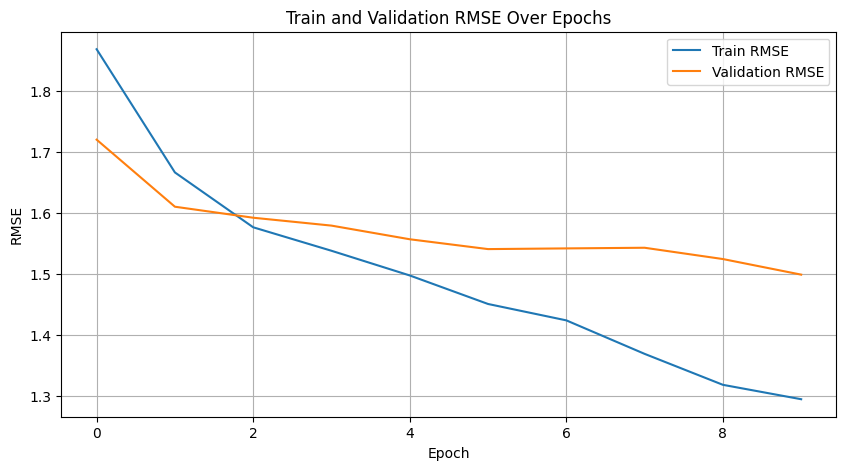

In [19]:
##### Plot RMSE for Train and Validation Sets

import numpy as np
import matplotlib.pyplot as plt

train_rmse_scores = [np.sqrt(loss) for loss in train_losses]
val_rmse_scores = [np.sqrt(mse) for mse in val_losses]

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_scores, label='Train RMSE')
plt.plot(val_rmse_scores, label='Validation RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train and Validation RMSE Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
##### Save Performance Data (to plot performances of all 3 models together)
import pandas as pd
import numpy as np

# assemble into a DataFrame
df_ESM2_model_official_10_epochs_MSE = pd.DataFrame({
    'epoch': np.arange(1, len(train_rmse_scores) + 1),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_rmse': train_rmse_scores,
    'val_rmse': val_rmse_scores,
    'val_mse': val_losses,
})

# save as CSV
df_ESM2_model_official_10_epochs_MSE.to_csv('ESM2_model_10_epochs_MSE', index=False)

Pearson r = 0.547 (p=9.4e-31)
Spearman ρ = 0.537
R² = 0.298


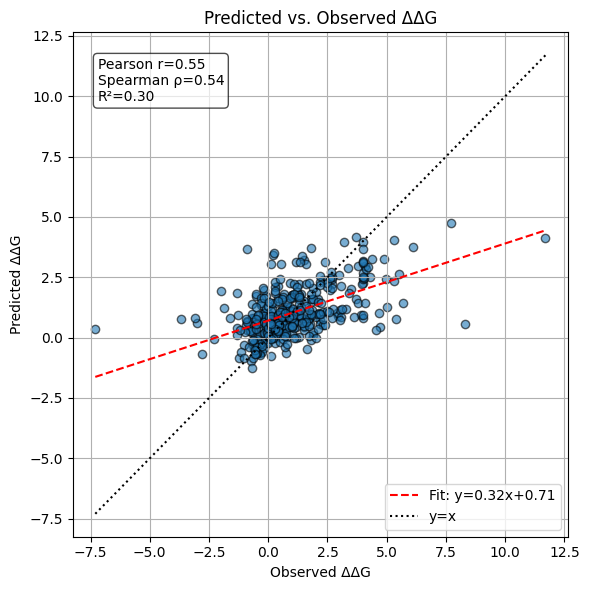

In [ ]:
##### Correlations Plot

import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Gather preds & targets
preds, targets = [], []
best_model.eval() # Evaluate the best model instead of the original model
with torch.no_grad():
    for _, _, ddg, meta in val_loader_official: # Iterate through the validation data loader
        ddg = ddg.to(device)
        # Extract the sequences from the metadata
        wt_seq = [meta['sequence'][i] for i in range(len(meta['sequence']))]
        mt_seq = [meta['mt_sequence'][i] for i in range(len(meta['mt_sequence']))]
        # Make predictions using the best model
        out = best_model(wt_seq, mt_seq)

        # Convert to numpy, flatten, then to list
        p = out.detach().cpu().numpy().flatten().tolist()
        t = ddg.detach().cpu().numpy().flatten().tolist()

        preds.extend(p)
        targets.extend(t)

preds   = np.array(preds)
targets = np.array(targets)

# 2) Compute metrics
pearson_r, pearson_p   = pearsonr(targets, preds)
spearman_rho, _        = spearmanr(targets, preds)
r2                     = r2_score(targets, preds)

print(f"Pearson r = {pearson_r:.3f} (p={pearson_p:.1e})")
print(f"Spearman ρ = {spearman_rho:.3f}")
print(f"R² = {r2:.3f}")

# 3) Plot with best‐fit
m, b = np.polyfit(targets, preds, 1)
x_line = np.linspace(targets.min(), targets.max(), 100)

plt.figure(figsize=(6,6))
plt.scatter(targets, preds, alpha=0.6, edgecolor='k')
plt.plot(x_line, m*x_line + b, 'r--', label=f'Fit: y={m:.2f}x+{b:.2f}')
plt.plot(x_line, x_line, 'k:', label='y=x')
plt.xlabel("Observed ΔΔG")
plt.ylabel("Predicted ΔΔG")
plt.title("Predicted vs. Observed ΔΔG")
plt.legend(loc="best")
plt.text(0.05, 0.95,
         f"Pearson r={pearson_r:.2f}\nSpearman ρ={spearman_rho:.2f}\nR²={r2:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Test MSE:  2.0655
📊 Test RMSE: 1.4372
📊 Test MAE:  1.0206
📊 Test R²:   0.3952


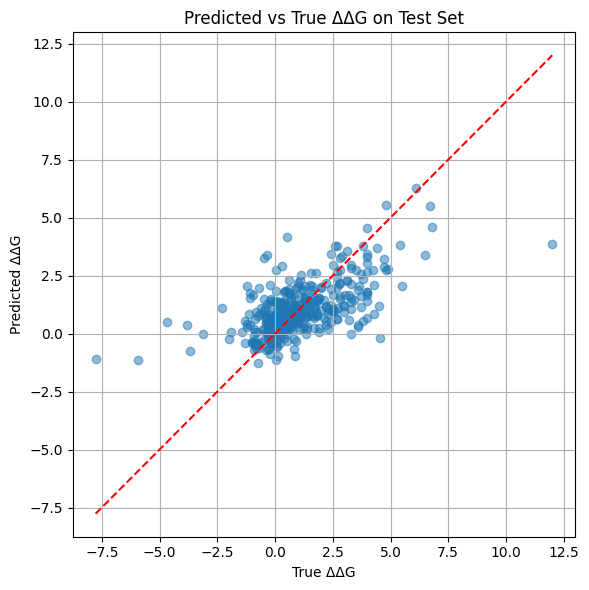

In [ ]:
best_model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for _, _, ddg, metadata in test_loader_official:
        wt_seqs = metadata['sequence']
        mt_seqs = metadata['mt_sequence']

        data_wt, data_mut, ddg = data_wt.to(device), data_mut.to(device), ddg.to(device)
        pred = best_model(wt_seqs, mt_seqs)

        all_preds.extend(pred.view(-1).cpu().numpy())
        all_targets.extend(ddg.view(-1).cpu().numpy())

# Metrics
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

mse = mean_squared_error(all_targets, all_preds)
rmse = math.sqrt(mse)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"📊 Test MSE:  {mse:.4f}")
print(f"📊 Test RMSE: {rmse:.4f}")
print(f"📊 Test MAE:  {mae:.4f}")
print(f"📊 Test R²:   {r2:.4f}")

# Plot: predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(all_targets, all_preds, alpha=0.5)
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')
plt.xlabel('True ΔΔG')
plt.ylabel('Predicted ΔΔG')
plt.title('Predicted vs True ΔΔG on Test Set')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model.esm_model.device

device(type='cuda', index=0)

In [ ]:
model.tokenizer

EsmTokenizer(name_or_path='facebook/esm2_t6_8M_UR50D', vocab_size=33, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'cls_token': '<cls>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<cls>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)